In [1]:
import torch
# import gpytorch
import GPy
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

import scipy.stats as st

import gc

In [2]:
# def loss(Xt, X, drift, dt, gamma=1):
#     H = silvermans_rule(X)
#     cross_entropy = -log_kde_pdf_per_point( Xt[:,-1,:-1], X, H) 
#     xf =Xt.reshape(Xt.shape[0] *Xt.shape[1], -1)
# #     import pdb;pdb.set_trace()
#     b = ( (0.5 / gamma ) * drift(xf)**2 * dt )
# #     import pdb; pdb.set_trace()
#     b = b.reshape(Xt.shape[0] , Xt.shape[1], -1).sum(dim=(1,2))
#     return (b + cross_entropy).mean()



def loss(Xt, X, drift, dt, gamma=1):
    
    return st.ks_2samp(Xt[:,-1,:-1].detach().cpu().flatten(), X.detach().cpu().flatten())[0]
    H = silvermans_rule(X)
    Ht = silvermans_rule(Xt[:,-1,:-1])
    
    cross_entropy = -log_kde_pdf_per_point( Xt[:,-1,:-1], X, H) 
    neg_entropy = log_kde_pdf_per_point( Xt[:,-1,:-1], Xt[:,-1,:-1], Ht) 
#     xf = Xt.reshape(Xt.shape[0] *Xt.shape[1], -1)
#     import pdb;pdb.set_trace()
#     b = ( (0.5 / gamma ) * drift(xf)**2 * dt )
#     import pdb; pdb.set_trace()
#     b = 0 * b.reshape(Xt.shape[0] , Xt.shape[1], -1).sum(dim=(1,2))
    return (0 + cross_entropy + 0).mean()

In [3]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [4]:
def plot_trajectories_both(Xts,t , Xts_, t_):

    fn = 14
    fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
    axs[1].set_xlabel("$t$", fontsize=fn)
    axs[1].set_ylabel("$x(t)$", fontsize=fn)
    axs[0].set_ylabel("$x(t)$", fontsize=fn)

    tt = axs[1].get_xticks()
    axs[1].set_xticks(tt.flatten() )
    axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    
    n =  Xts.shape[0]
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    n =  Xts_.shape[0]
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.3, label=label)

    axs[1].legend(fontsize=fn)
    axs[0].legend(fontsize=fn)

    plt.show() 
    
    
    
def plot_trajectories_both_(Xts,t , Xts_, t_):

    fn = 14
    fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
    axs[1].set_xlabel("$t$", fontsize=fn)
    axs[1].set_ylabel("$x(t)$", fontsize=fn)
    axs[0].set_ylabel("$x(t)$", fontsize=fn)

    tt = axs[1].get_xticks()
    axs[1].set_xticks(tt.flatten() )
    axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    
    n =  Xts.shape[0]
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs[0].plot(t.cpu().flatten(), Xts[i,:,:].detach().cpu().numpy().flatten(), 'g', alpha=0.3,  label=label)

    n =  Xts_.shape[0]
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :].detach().cpu().numpy().flatten(), 'm', alpha=0.3, label=label)

    axs[1].legend(fontsize=fn)
    axs[0].legend(fontsize=fn)

    plt.show() 

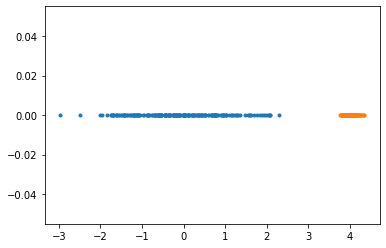

In [5]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


npr.seed(100)
n = 200
n_2 = int(n * 1.0 / 2)
# n_2 = int(n * 1.0 / 2.0)


X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.1 * npr.randn(n_2).reshape(-1,1) + 4
X22 =  0.1 * npr.randn(n_2).reshape(-1,1) + 4
X23 =  3 * npr.randn(n_2).reshape(-1,1) + 0

X2 = np.concatenate((X21, X22), axis=0)
X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [6]:


def plot_trajectories_( Xts, t):

    fn = 14
    fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
    axs.set_ylabel("$x(t)$", fontsize=fn)



    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    plt.show()    
    

def plot_trajectories_2( Xts, t):

    fn = 14
    fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
    axs.set_ylabel("$x(t)$", fontsize=fn)



    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    plt.show()  

In [7]:
def get_drift_data(SAMPLES, dt):

    X = (SAMPLES[:,:,:].flip(1))[:,:,:-1]

    Ys = (X[:,1:,:] - X[:,:-1,:]).reshape(-1,1) / dt

    Xs =  X[:,:-1,:].reshape(-1,1)

    ts = SAMPLES[:,:-1,-1] #torch.cat((Q_1[:,:-1,-1], torch.ones(Q_1[:,:-1,-1].shape[0],1).double().cuda() + dt), dim=1)#.reshape(-1,1) 
    Xs  = torch.cat((Xs,ts.reshape(-1,1) ),dim=1)
    return Xs, Ys

In [8]:
# initialize likelihood and model
def set_up_gp(Xs, Ys):

    kernel = GPy.kern.RBF(input_dim=dim, variance=1., lengthscale=1.)

    m = GPy.models.GPRegression(Xs[...,:dim].detach().cpu().numpy(),Ys.detach().cpu().numpy(),kernel)
    return m 


In [9]:
def gp_drift_mean(X, m):
#     X = X[...,:-1]
    X =(X.detach().cpu().numpy())
    mean = m.predict(X[...,:dim])[0]

    return torch.tensor(mean).double().cuda()


In [10]:
def divergence(f, inputs, e=1e-12):
    inputs_p_e = inputs.clone()
    inputs_p_e[...,:-1] += e
    grads_ = (f(inputs_p_e) - f(inputs)) / e
    return grads_.sum(dim=1)


def loss_bound(Xt, X):
    
    H = silvermans_rule(X)
    
    cross_entropy = -log_kde_pdf_per_point( Xt[:,0,:-1], X, H) 

    return  (cross_entropy).mean()


def loss(Xt, X, drift_f, drift_b, dt, gamma=1, sign=1):
    Xt = Xt[:,:-1,:]
    xf = Xt[:,:,:].reshape(Xt.shape[0] * (Xt.shape[1] ), -1)
    b_1 =  drift_f(xf).reshape(Xt.shape[0] , Xt.shape[1], -1)  #+ (0) * (divergence(drift_b, xf)) / gamma
    diff = (( (0.5 / gamma ) * (b_1)**2 * dt ))
    

    b =  diff.sum(dim=(1,2)) 

    t= Xt[0,:,-1].flatten()
    return b.mean() 

In [11]:
time = True

dim = 2 if time else 1

drift_q = lambda x: 0
N = 60
dt = 1.0 / N

npr.seed(100)
torch.random.manual_seed(100)
# Estimating the backward drift of brownian motion
t, Q_2 = solve_sde_RK(alfa=drift_q, beta=1.0, X0=X1, dt=dt, N=int(1/dt)+1)

Xs2, Ys2 = get_drift_data(Q_2, dt)

m_p = set_up_gp(Xs2, Ys2)

drift_p = lambda x: gp_drift_mean(x, m_p)

def flip(x):
    x[:,1] = 1- x[:,1] 
    return x

loss_f, loss_b  = [], [] 
loss_f_bound, loss_b_bound  = [], [] 
# loss_f.append(loss(Q_2, X2, drift_p, dt, gamma=1.0))
for i in tqdm(range(200)):
    
    # backward
    t, Q_1 = solve_sde_RK(alfa=drift_p, beta=1.0, X0=X2,dt=dt, N=int(1/dt)+1)
    
    Xs, Ys = get_drift_data(Q_1, dt)
    
    m_q = set_up_gp(Xs, Ys)
    
    drift_q = lambda x: gp_drift_mean(x, m_q)

    
    T, M = solve_sde_RK(alfa=drift_q, beta=1, X0=Q_1[:,-1,:-1],dt=dt, N=int(1/dt)+1)
    
    loss_b.append(loss(M, X1, drift_q, lambda x_: -drift_p(flip(x_)), dt, gamma=1.0, sign=-1))
    loss_b_bound.append(loss_bound(M, X1))
    
#     plot_trajectories_(M, T)
    
    # forward
    t, Q_2 = solve_sde_RK(alfa=drift_q, beta=1.0, X0=X1,dt=dt, N=int(1/dt)+1)
    
    Xs2, Ys2 = get_drift_data(Q_2, dt)
    
    m_p = set_up_gp(Xs2, Ys2)
    
    drift_p = lambda x: gp_drift_mean(x, m_p)
    
    
    T2, M2 = solve_sde_RK(alfa=drift_p, beta=1, X0=Q_2[:,-1,:-1],dt=dt, N=int(1/dt)+1)
    
#     loss_b.append(loss(M2, X2, drift_q, lambda x_: drift_p(x_), dt, gamma=1.0, sign=1))
    loss_f.append(loss(M2, X2, lambda x_: -drift_p(x_), lambda x: drift_q(flip(x)), dt, gamma=1.0, sign=1))
    loss_f_bound.append(loss_bound(M2, X2))
    gc.collect()
#     loss_f.append(loss(M2, X2, lambda x_: drift_p(x_), drift_q, dt, gamma=1.0, sign=1))
#     plot_trajectories_(M2,  T2)
#     plot_trajectories_both(M.flip(1), T, M2, T2)

3935

In [24]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('NN', 1064),
 ('X21', 912),
 ('X22', 912),
 ('X23', 912),
 ('partial', 400),
 ('divergence', 144),
 ('drift_p', 144),
 ('drift_q', 144),
 ('flip', 144),
 ('get_drift_data', 144),
 ('gp_drift_mean', 144),
 ('log_kde_pdf_per_point', 144),
 ('loss', 144),
 ('loss_bound', 144),
 ('plot_trajectories_', 144),
 ('plot_trajectories_2', 144),
 ('plot_trajectories_both', 144),
 ('plot_trajectories_both_', 144),
 ('set_up_gp', 144),
 ('silvermans_rule', 144),
 ('solve_sde_RK', 144),
 ('loss_b', 104),
 ('loss_b_bound', 104),
 ('loss_f', 104),
 ('loss_f_bound', 104),
 ('nn', 88),
 ('np', 88),
 ('npr', 88),
 ('plt', 88),
 ('st', 88),
 ('M', 80),
 ('M2', 80),
 ('Q_1', 80),
 ('Q_2', 80),
 ('T', 80),
 ('T2', 80),
 ('X1', 80),
 ('X2', 80),
 ('Xs', 80),
 ('Xs2', 80),
 ('Ys', 80),
 ('Ys2', 80),
 ('t', 80),
 ('m_p', 64),
 ('m_q', 64),
 ('N', 28),
 ('dim', 28),
 ('i', 28),
 ('n', 28),
 ('n_2', 28),
 ('dt', 24)]

In [14]:
loss_b

[tensor(3.1129, device='cuda:0', dtype=torch.float64),
 tensor(8.5462, device='cuda:0', dtype=torch.float64),
 tensor(8.7553, device='cuda:0', dtype=torch.float64),
 tensor(8.5318, device='cuda:0', dtype=torch.float64),
 tensor(8.6211, device='cuda:0', dtype=torch.float64),
 tensor(8.9738, device='cuda:0', dtype=torch.float64),
 tensor(9.0387, device='cuda:0', dtype=torch.float64),
 tensor(8.9879, device='cuda:0', dtype=torch.float64),
 tensor(9.2260, device='cuda:0', dtype=torch.float64),
 tensor(9.1068, device='cuda:0', dtype=torch.float64),
 tensor(9.1286, device='cuda:0', dtype=torch.float64),
 tensor(9.0892, device='cuda:0', dtype=torch.float64),
 tensor(9.4112, device='cuda:0', dtype=torch.float64),
 tensor(9.4801, device='cuda:0', dtype=torch.float64),
 tensor(9.3776, device='cuda:0', dtype=torch.float64),
 tensor(9.2435, device='cuda:0', dtype=torch.float64),
 tensor(9.3841, device='cuda:0', dtype=torch.float64),
 tensor(9.3886, device='cuda:0', dtype=torch.float64),
 tensor(9.

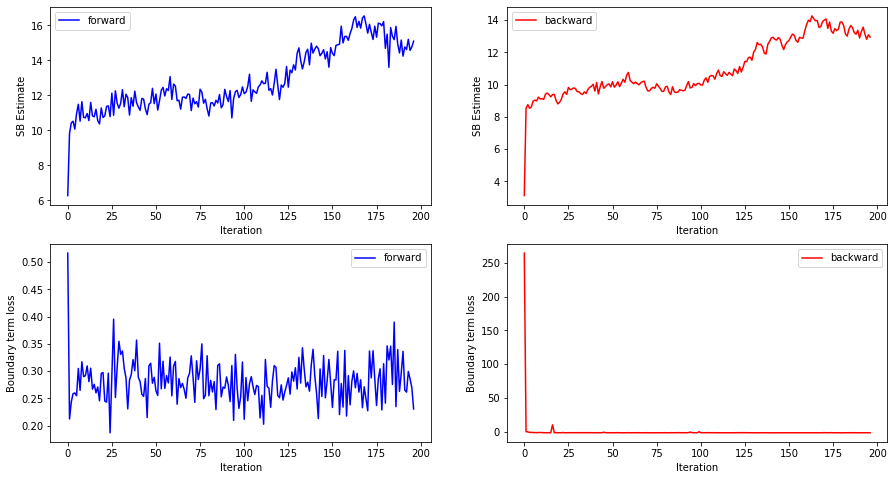

In [25]:
fig, axs = plt.subplots(2,2, sharey=False, figsize=(15, 8))
axs[0,0].plot(loss_f[:197], color="blue", label="forward")
axs[0,0].set_xlabel("Iteration")
axs[0,0].set_ylabel("SB Estimate")
axs[0,0].legend()
axs[0,1].plot(loss_b[:197], color="red", label="backward")
axs[0,1].set_xlabel("Iteration")
axs[0,1].set_ylabel("SB Estimate")
axs[0,1].legend()



axs[1,0].plot(loss_f_bound[:197], color="blue", label="forward")
axs[1,0].set_xlabel("Iteration")
axs[1,0].set_ylabel("Boundary term loss")
axs[1,0].legend()
axs[1,1].plot(loss_b_bound[:197], color="red", label="backward")
axs[1,1].set_xlabel("Iteration")
axs[1,1].set_ylabel("Boundary term loss")
axs[1,1].legend()



plt.savefig("SB_gp_bigvar_epochs_samp_200.png")


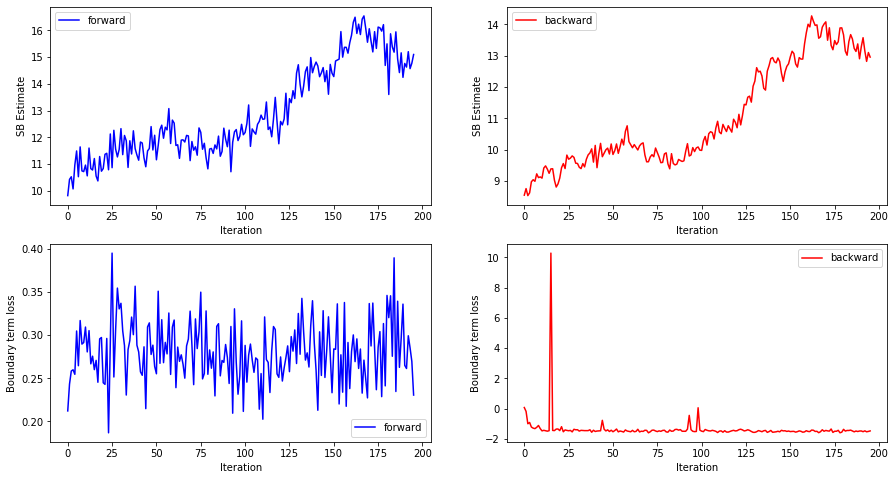

In [26]:
fig, axs = plt.subplots(2,2, sharey=False, figsize=(15, 8))
axs[0,0].plot(loss_f[1:197], color="blue", label="forward")
axs[0,0].set_xlabel("Iteration")
axs[0,0].set_ylabel("SB Estimate")
axs[0,0].legend()
axs[0,1].plot(loss_b[1:197], color="red", label="backward")
axs[0,1].set_xlabel("Iteration")
axs[0,1].set_ylabel("SB Estimate")
axs[0,1].legend()



axs[1,0].plot(loss_f_bound[1:197], color="blue", label="forward")
axs[1,0].set_xlabel("Iteration")
axs[1,0].set_ylabel("Boundary term loss")
axs[1,0].legend()
axs[1,1].plot(loss_b_bound[1:197], color="red", label="backward")
axs[1,1].set_xlabel("Iteration")
axs[1,1].set_ylabel("Boundary term loss")
axs[1,1].legend()



plt.savefig("SB_gp_bigvar_epochs_samp_200_1_plus.png")

In [12]:
def plot_trajectories_both(Xts,t , Xts_, t_, name=None):

    fn = 14
    fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
    axs[1].set_xlabel("$t$", fontsize=fn)
    axs[1].set_ylabel("$x(t)$", fontsize=fn)
    axs[0].set_ylabel("$x(t)$", fontsize=fn)

    tt = axs[1].get_xticks()
    axs[1].set_xticks(tt.flatten() )
    axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    
    n =  Xts.shape[0]
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    n =  Xts_.shape[0]
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.3, label=label)

    axs[1].legend(fontsize=fn)
    axs[0].legend(fontsize=fn)
    
    if name is not None:
        plt.savefig(name)

    plt.show() 

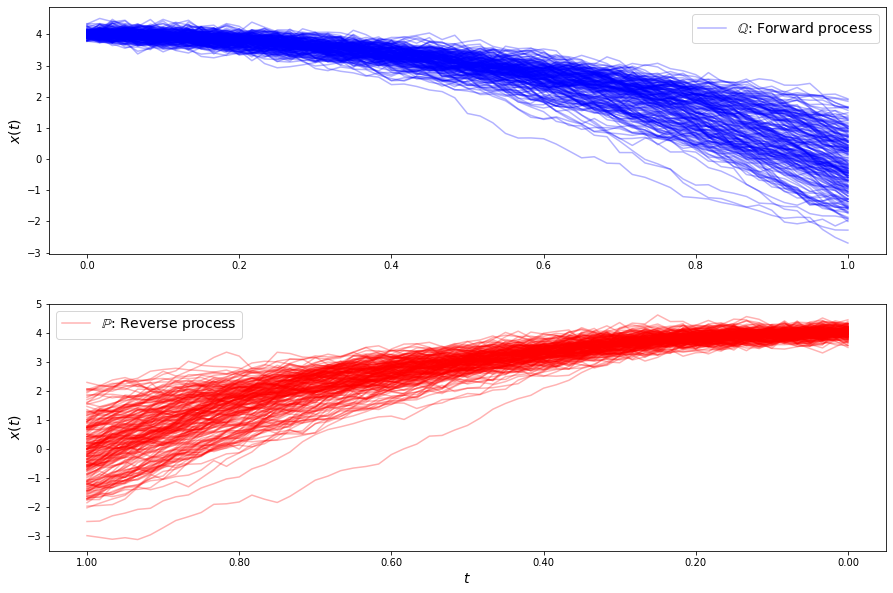

In [13]:
t, Xts = solve_sde_RK(alfa=drift_q, beta=1, X0=X1,dt=dt, N=int(1/dt)+1)
t_, Xts_ = solve_sde_RK(alfa=drift_p, beta=1, X0=X2,dt=dt, N=int(1/dt)+1)

plot_trajectories_both(Xts, t, Xts_, t_)

In [28]:
import scipy.stats as st

print(st.ks_2samp(Xts[:,-1,:-1].flatten().detach().cpu().numpy(), X2.flatten().detach().cpu().numpy()))
print(st.ks_2samp(Xts_[:,-1,:-1].flatten().detach().cpu().numpy(), X1.flatten().detach().cpu().numpy()))

Ks_2sampResult(statistic=0.19, pvalue=0.0014264303851701861)
Ks_2sampResult(statistic=0.07, pvalue=0.7125821300149116)


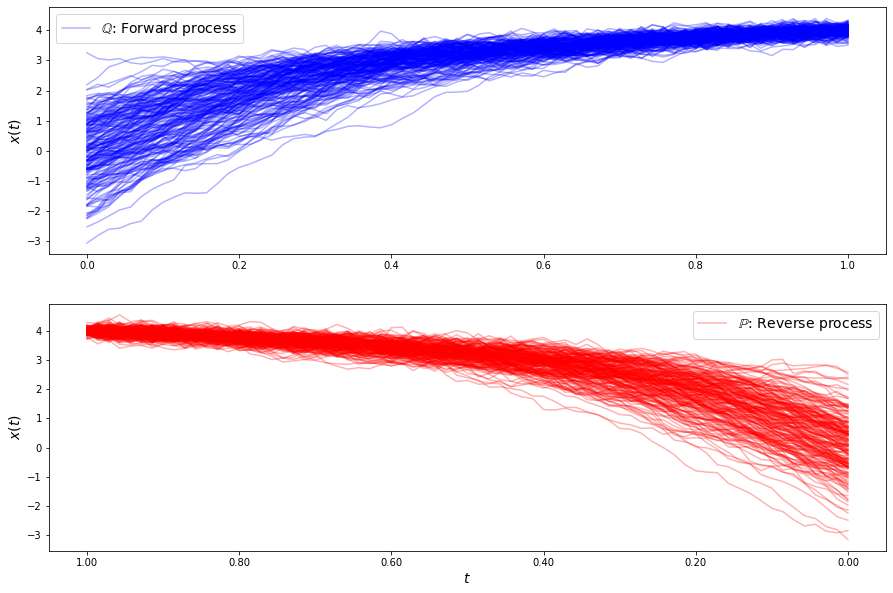

In [24]:
plot_trajectories_both(Xts, t, Xts_, t_, name="gp_bigvar_bimodal_boundaires_trajectories.png")

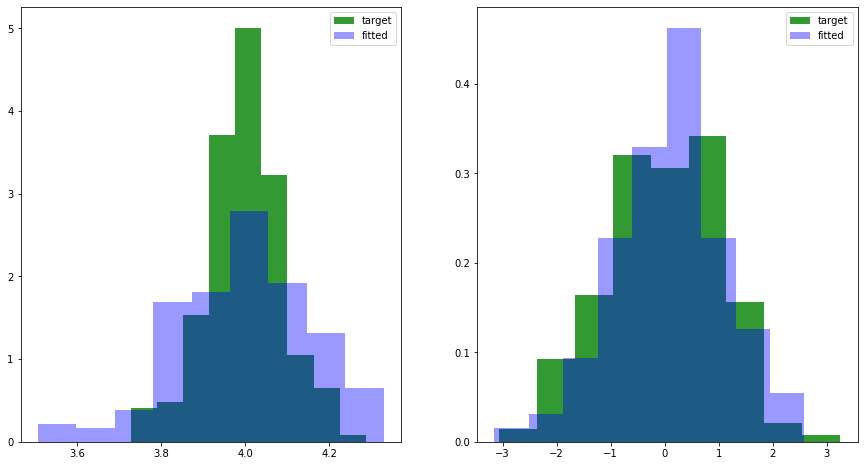

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))


bins = 9
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");



xx = torch.linspace(float(min(X1.min().detach().cpu().numpy(), Xts_[:,-1,:-1].min().detach().cpu().numpy() )) -3 ,
                    float(max(X1.max().detach().cpu().numpy(), Xts_[:,-1,:-1].max().detach().cpu().numpy() ))+3).reshape(-1,1).cuda().double()



# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()
xx = torch.linspace(float(min(X2.min().detach().cpu().numpy(), Xts[:,-1,:-1].min().detach().cpu().numpy() )) -3 ,
                    float(max(X2.max().detach().cpu().numpy(), Xts[:,-1,:-1].max().detach().cpu().numpy() ))+3).reshape(-1,1).cuda().double()



bins = 9
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()
axs[1].legend()
plt.savefig("gp_bigvar_boundaires.png")